In [1]:
! pip install --upgrade google-cloud-aiplatform google-cloud-storage

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
import base64
import sys
import time
import os
import json
import uuid
from typing import List

from tqdm import tqdm
import numpy as np
import pandas as pd
import requests
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image as PILIm

from google.cloud import storage, aiplatform
from google.cloud.aiplatform import MatchingEngineIndex, MatchingEngineIndexEndpoint

from vertexai.preview.language_models import TextEmbeddingModel
from vertexai.preview.vision_models import MultiModalEmbeddingModel, Image

from concurrent.futures import ThreadPoolExecutor
import glob

In [4]:
PROJECT_ID = "test-vertex-400014"
DATA_BUCKET = "gagata-data-bucket"
prefix = "wikiart/"

INDEX_ID = "6936379054987673600"
INDEX_ENDPOINT_ID = "2431090577756913664"

In [ ]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [5]:
aiplatform.init(project=PROJECT_ID, location="us-central1")

In [6]:
def list_gcs_files(bucket_name: str, prefix: str = "") -> List[str]:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix, delimiter="/")

    files = []
    for blob in blobs:
        files.append(blob.name)

    return files[1:]


# def load_image_bytes(image_uri: str) -> bytes:
#     download_image_from_gcs(DATA_BUCKET, image_uri)
#     image_bytes = open(image_uri, "rb").read()
#     return image_bytes


def download_image_from_gcs(image_uri: str) -> bytes:
    client = storage.Client()
    bucket = client.bucket(DATA_BUCKET)
    blob = bucket.blob(image_uri)
    blob.download_to_filename(image_uri)

In [7]:
files_list = list_gcs_files(bucket_name=DATA_BUCKET, prefix=prefix)

In [8]:
if not os.path.exists(prefix):
    os.makedirs(prefix)

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(download_image_from_gcs, files_list), total=len(files_list)))

print(f'\nSuccessfully downloaded {len(files_list)} images')

100%|██████████| 1418/1418 [02:46<00:00,  8.52it/s]


In [9]:
# def dot_product_distance(
#     text_embedding: np.ndarray, image_embeddings: np.ndarray
# ) -> np.ndarray:
#     return np.dot(text_embedding, image_embeddings.T)

In [10]:
img_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

In [11]:
def preprocess_image(image_path):
  with PILIm.open(image_path) as im:
    im.thumbnail((512, 512), PILIm.ANTIALIAS)
    im = im.convert('RGB')
    resized_image_path = os.path.join(prefix, os.path.basename(image_path))
    im.save(resized_image_path)

In [12]:
image_paths = glob.glob('wikiart/*.jpg')

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(preprocess_image, image_paths), total=len(image_paths)))

print(f'\nSuccessfully preprocessed {len(image_paths)} images')

<ipython-input-11-3aceb1136526>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail((512, 512), PILIm.ANTIALIAS)
100%|██████████| 1418/1418 [00:16<00:00, 87.78it/s]

Successfully preprocessed 1418 images


In [13]:
images_to_search = [Image.load_from_file(image_file) for image_file in image_paths]

In [18]:
def process_image_batch(batch):
    embeddings = []
    for search_image in batch:
        try:
            embeddings.append(img_model.get_embeddings(image=search_image).image_embedding)
        except Exception as ex:
            print(ex)
    return embeddings

In [19]:
batch_size = 5
image_batches = [images_to_search[i:i + batch_size] for i in range(0, len(images_to_search), batch_size)]

In [20]:
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_image_batch, image_batches), total=len(image_batches)))

print(f'\nSuccessfully processed {len(image_batches)*batch_size} images')

100%|██████████| 284/284 [01:12<00:00,  3.94it/s]

Successfully processed 1420 images


In [21]:
images_to_search_embeddings = [embedding for batch_result in results for embedding in batch_result]

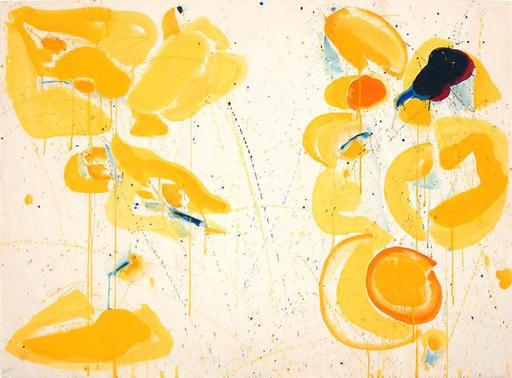

In [41]:
query_image = Image.load_from_file("wikiart/57727f3eedc2cb3880ed755b.jpg")
query_image.show()
query_image_embeddings = img_model.get_embeddings(image=query_image).image_embedding

In [23]:
similarities = [cosine_similarity([query_image_embeddings], [images_to_search_embeddings[i]])[0][0] for i in range(len(images_to_search))]

In [24]:
sorted_images = np.array(image_paths)[np.argsort(similarities)][::-1]

wikiart/57727016edc2cb3880bceb88.jpg


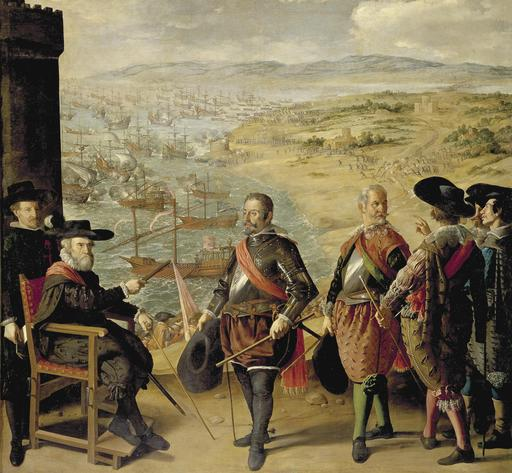

wikiart/5772847bedc2cb3880fdede7.jpg


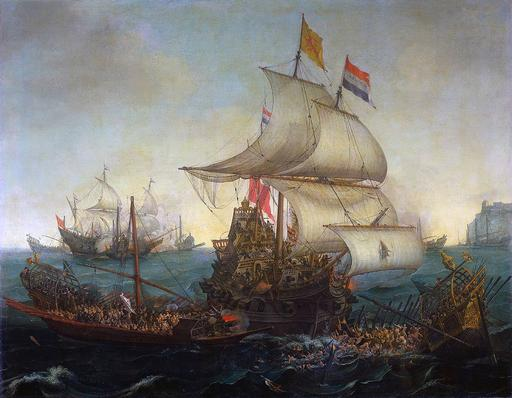

wikiart/5772847bedc2cb3880fdee17.jpg


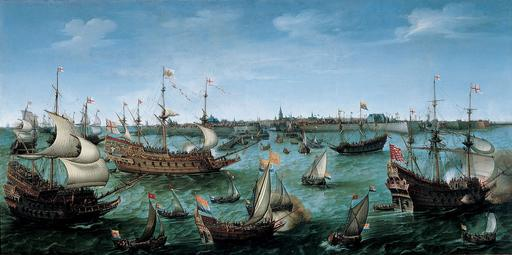

wikiart/5772848dedc2cb3880fe5c7f.jpg


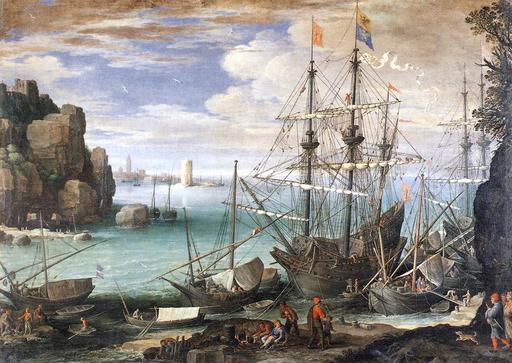

wikiart/57727d75edc2cb3880e7cc7c.jpg


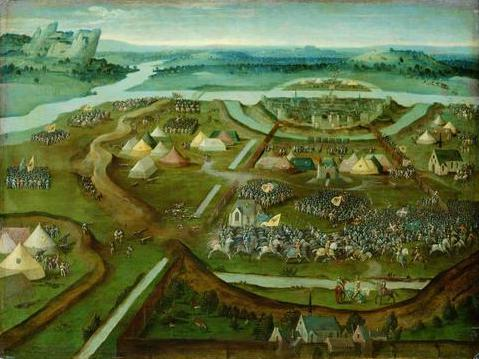

wikiart/57727e01edc2cb3880e99cc7.jpg


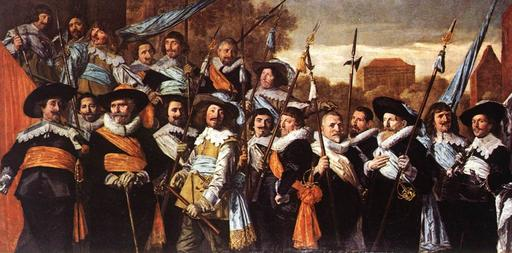

wikiart/5772847bedc2cb3880fdedd7.jpg


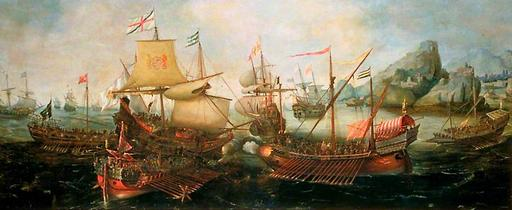

wikiart/5899c27eedc2c97aacea06a3.jpg


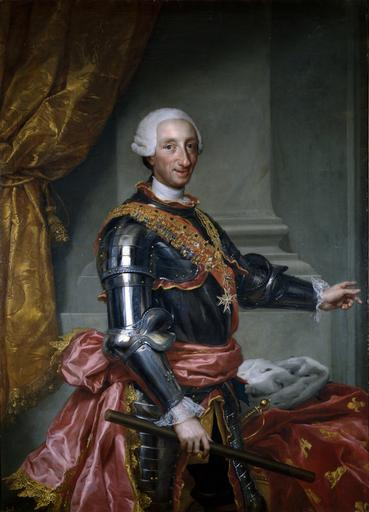

wikiart/57727cfaedc2cb3880e61524.jpg


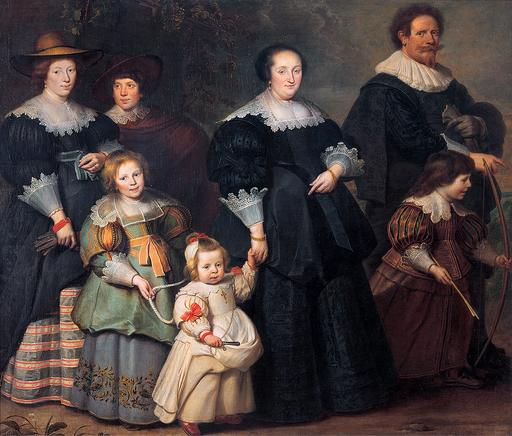

wikiart/57728325edc2cb3880f9fd25.jpg


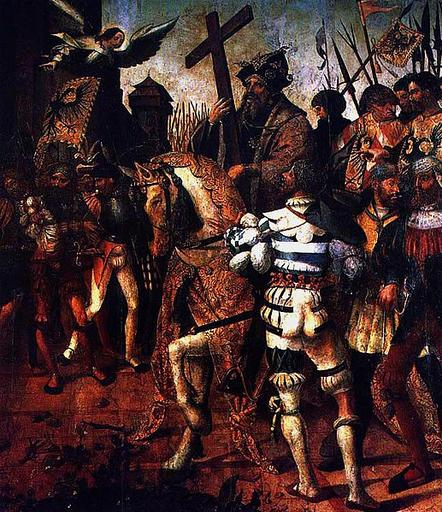

In [25]:
for image_file in sorted_images[:10]:
    print(image_file)
    img = Image.load_from_file(image_file)
    img.show()

In [ ]:
import json

with open('image_embeddings.json', 'w') as f:
    for i, embedding in enumerate(images_to_search_embeddings):
        f.write(json.dumps({
            "id": os.path.basename(image_paths[i])[:-4],
            "embedding": embedding
        }) + '\n')


In [ ]:
!gsutil -m cp image_embeddings.json gs://gagata-vertex-bucket/indexes/

Copying file://image_embeddings.json [Content-Type=application/json]...
\
Operation completed over 1 objects/28.0 MiB.                                     


In [28]:
index = MatchingEngineIndex(index_name=INDEX_ID)

In [29]:
index_endpoint = MatchingEngineIndexEndpoint(
    index_endpoint_name=INDEX_ENDPOINT_ID
)

In [ ]:
index.update_embeddings("gs://gagata-vertex-bucket/indexes/")

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Updating MatchingEngineIndex index: projects/260512411915/locations/us-central1/indexes/6936379054987673600
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Update MatchingEngineIndex index backing LRO: projects/260512411915/locations/us-central1/indexes/6936379054987673600/operations/1308654613578121216
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:MatchingEngineIndex index Updated. Resource name: projects/260512411915/locations/us-central1/indexes/6936379054987673600


resource name: projects/260512411915/locations/us-central1/indexes/6936379054987673600

In [ ]:
index_endpoint.deploy_index(
    index=index, deployed_index_id=uuid.uuid4().hex)

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/260512411915/locations/us-central1/indexEndpoints/2431090577756913664
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/260512411915/locations/us-central1/indexEndpoints/2431090577756913664/operations/3650526419810779136
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/260512411915/locations/us-central1/indexEndpoints/2431090577756913664


resource name: projects/260512411915/locations/us-central1/indexEndpoints/2431090577756913664

In [30]:
DEPLOYED_INDEX_ID = "dc6ef62e12c04bc2a1ac8c6ff7c2de68"

In [42]:
matches = index_endpoint.match(DEPLOYED_INDEX_ID, queries=[query_image_embeddings], num_neighbors=10)
matches

[[MatchNeighbor(id='57727f3eedc2cb3880ed755b', distance=0.9999998807907104),
  MatchNeighbor(id='128', distance=0.9711272716522217),
  MatchNeighbor(id='581', distance=0.8013314604759216),
  MatchNeighbor(id='57728047edc2cb3880f0a302', distance=0.7872942686080933),
  MatchNeighbor(id='460', distance=0.7729554176330566),
  MatchNeighbor(id='57728500edc2cb3880ffb33c', distance=0.7622829675674438),
  MatchNeighbor(id='57728287edc2cb3880f80685', distance=0.7554721236228943),
  MatchNeighbor(id='577281f9edc2cb3880f62b05', distance=0.748824417591095),
  MatchNeighbor(id='1281', distance=0.7483751773834229),
  MatchNeighbor(id='57727f1aedc2cb3880ecec81', distance=0.7466403245925903)]]

57727f3eedc2cb3880ed755b


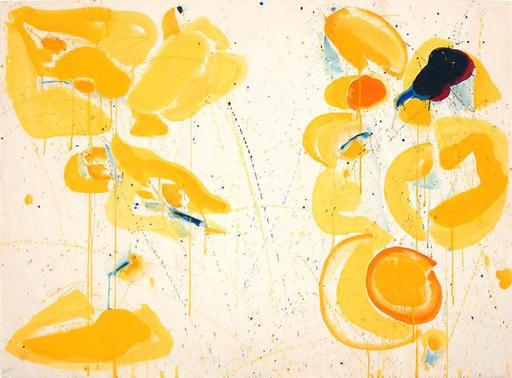

57728047edc2cb3880f0a302


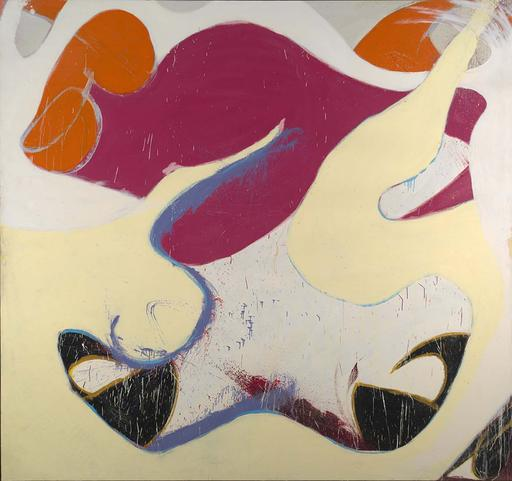

57728500edc2cb3880ffb33c


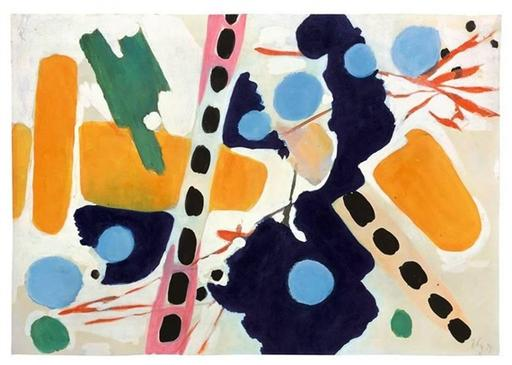

57728287edc2cb3880f80685


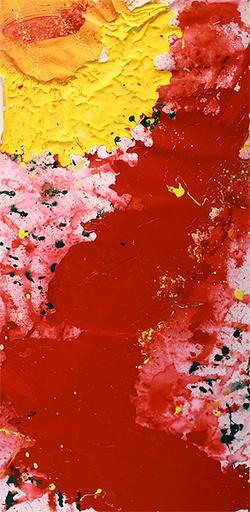

577281f9edc2cb3880f62b05


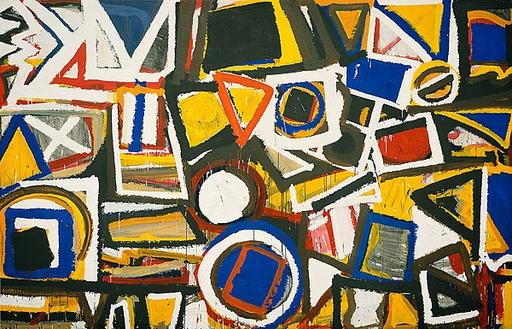

57727f1aedc2cb3880ecec81


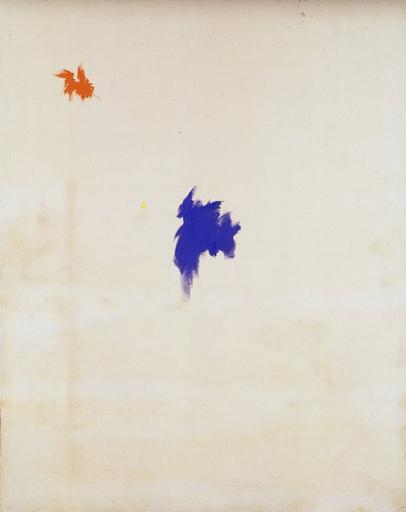

In [43]:
for match in matches[0]:
    if len(match.id) <= 4: # temporary, because there are old ids still in the index
      continue
    print(match.id)
    img = Image.load_from_file(f"wikiart/{match.id}.jpg")
    img.show()